
                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 1000, 2, 10, 9)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 2, 10, 9)


Initializing configurations: 100%|██████████| 10/10 [00:00<00:00, 903.75it/s]

Execution Method: parallelize_simulations



Flattening results: 100%|██████████| 10/10 [00:00<00:00, 916.33it/s]

Total execution time: 0.83s


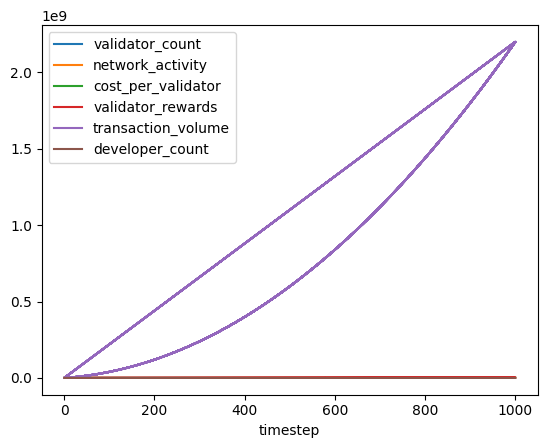

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

# Define the system parameters
initial_validators = 1000
initial_stake = 2000
network_activity = 10000
initial_cost_per_validator = 250
subnet_count = 50
initial_rewards = 0
initial_transaction_volume = 0
initial_developer_count = 0
initial_user_activity = 0

# Define the initial state
initial_state = {
    'validator_count': initial_validators,
    'average_stake': initial_stake,
    'network_activity': network_activity,
    'cost_per_validator': initial_cost_per_validator,
    'subnet_count': subnet_count,
    'validator_rewards': initial_rewards,
    'transaction_volume': initial_transaction_volume,
    'developer_count': initial_developer_count,
    'user_activity': initial_user_activity
}

# Define system parameters
params = {
    'ACP_77_fees': 80,  # USD/month
    'current_fees': 250  # USD/month
}

# Define the policy functions
def apply_acp_77_fees(params, step, sL, s):
    return {'cost_per_validator': params['ACP_77_fees']}

def apply_current_fees(params, step, sL, s):
    return {'cost_per_validator': params['current_fees']}

def distribute_rewards(params, step, sL, s):
    rewards = s['network_activity'] * 0.01  # Simplified logic for reward calculation
    return {'validator_rewards': rewards}

def update_transaction_volume(params, step, sL, s):
    volume = s['network_activity'] * 10  # Simplified logic for transaction volume
    return {'transaction_volume': volume}

def incentivize_developers(params, step, sL, s):
    new_developers = 5 if s['cost_per_validator'] < params['current_fees'] else 1
    return {'developer_count': s['developer_count'] + new_developers}

# Define the state transition functions
def update_validator_count(params, step, sL, s, _input):
    y = 'validator_count'
    new_state = s[y] + 50 if _input['cost_per_validator'] < params['current_fees'] else s[y] - 50
    return (y, new_state)

def update_network_activity(params, step, sL, s, _input):
    y = 'network_activity'
    new_state = s[y] + 100
    return (y, new_state)

def update_cost_per_validator(params, step, sL, s, _input):
    y = 'cost_per_validator'
    new_state = _input['cost_per_validator']
    return (y, new_state)

def update_rewards(params, step, sL, s, _input):
    y = 'validator_rewards'
    new_state = s[y] + _input['validator_rewards']
    return (y, new_state)

def update_volume(params, step, sL, s, _input):
    y = 'transaction_volume'
    new_state = s[y] + _input['transaction_volume']
    return (y, new_state)

def update_developer_count(params, step, sL, s, _input):
    y = 'developer_count'
    new_state = _input['developer_count']
    return (y, new_state)

# Define the partial state update blocks
partial_state_update_blocks = [
    {
        'policies': {
            'fee_policy': apply_acp_77_fees,
            'reward_policy': distribute_rewards,
            'volume_policy': update_transaction_volume,
            'developer_policy': incentivize_developers
        },
        'variables': {
            'cost_per_validator': update_cost_per_validator,
            'validator_count': update_validator_count,
            'network_activity': update_network_activity,
            'validator_rewards': update_rewards,
            'transaction_volume': update_volume,
            'developer_count': update_developer_count
        }
    },
    {
        'policies': {
            'fee_policy': apply_current_fees,
            'reward_policy': distribute_rewards,
            'volume_policy': update_transaction_volume,
            'developer_policy': incentivize_developers
        },
        'variables': {
            'cost_per_validator': update_cost_per_validator,
            'validator_count': update_validator_count,
            'network_activity': update_network_activity,
            'validator_rewards': update_rewards,
            'transaction_volume': update_volume,
            'developer_count': update_developer_count
        }
    }
]

# Configure the simulation
sim_config = config_sim(
    {
        'N': 10,  # Number of Monte Carlo runs
        'T': range(1000),  # Number of timesteps
        'M': params,  # System parameters
    }
)

# Create the experiment
exp = Experiment()
exp.append_configs(
    sim_configs=sim_config,
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks
)

# Execute the simulation
exec_mode = ExecutionMode()
exec_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()

# Process the results
df = pd.DataFrame(raw_result)
df.plot(x='timestep', y=['validator_count', 'network_activity', 'cost_per_validator', 'validator_rewards', 'transaction_volume', 'developer_count'])
plt.show()

In [12]:
df.head(10)

,validator_count,average_stake,network_activity,cost_per_validator,subnet_count,validator_rewards,transaction_volume,developer_count,user_activity,simulation,subset,run,substep,timestep
0,1000,2000,10000,250,50,0.0,0,0,0,0,0,1,0,0
1,1050,2000,10100,80,50,100.0,100000,1,0,0,0,1,1,1
2,1000,2000,10200,250,50,201.0,201000,6,0,0,0,1,2,1
3,1050,2000,10300,80,50,303.0,303000,7,0,0,0,1,1,2
4,1000,2000,10400,250,50,406.0,406000,12,0,0,0,1,2,2
5,1050,2000,10500,80,50,510.0,510000,13,0,0,0,1,1,3
6,1000,2000,10600,250,50,615.0,615000,18,0,0,0,1,2,3
7,1050,2000,10700,80,50,721.0,721000,19,0,0,0,1,1,4
8,1000,2000,10800,250,50,828.0,828000,24,0,0,0,1,2,4
9,1050,2000,10900,80,50,936.0,936000,25,0,0,0,1,1,5


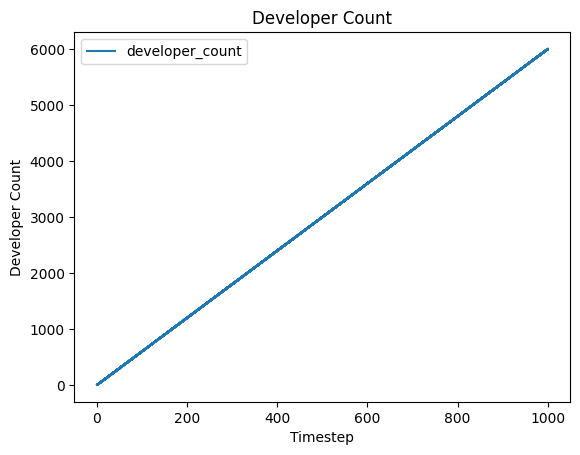

In [13]:
# Plot for Developer Count
df.plot(x='timestep', y='developer_count')
plt.title('Developer Count')
plt.xlabel('Timestep')
plt.ylabel('Developer Count')
plt.show()


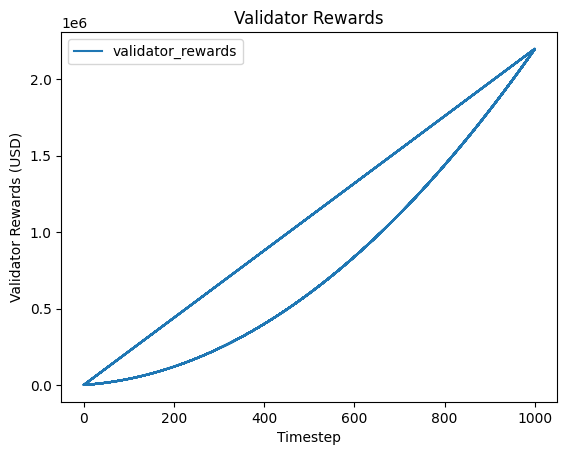

In [15]:
# Plot for Validator Rewards
df.plot(x='timestep', y='validator_rewards')
plt.title('Validator Rewards')
plt.xlabel('Timestep')
plt.ylabel('Validator Rewards (USD)')
plt.show()
